# Ajuste de modelo SEIR

Ajuste de un modelo SEIR discreto de paso diario a casos observados, y proyección de casos futuros.

## Variables de entrada

### Datos

Los datos a utilizar se toman del archivo csv de datos abiertos del Ministerio de Salud, con datos del SISA con fecha de corte diaria a las 17:45. 

In [173]:
municipio = 'Lobería'
poblacion = 17523

### Parámetros

Valores para los parámetros del modelo y otras variables necesarias para las simulaciones: 

- El valor del parámetro R0 es el que se va a ajustar a los datos, por lo que el valor que se indica acá se toma sólo como valor inicial. Los parámetros alpha y gamma son fijos, y el parámetro beta se calcula a partir de R0 y gamma.

- Los parámetros se ajustan para 3 períodos de tiempo de distinta duración, tomando los datos de, por ejemplo, las últimas 1, 2 y 3 semanas. Para asegurar un mejor ajuste, en cada caso se inician las simulaciones unos días antes ('lag') del período a considerar.

- Luego para cada ajuste de parámetros, se realiza una proyección hacia el futuro, una cierta cantidad de días.

In [174]:
# parámetros del modelo SEIR
R0 = 1.5
alpha = 1 / 3
gamma = 1 / 7
beta = R0 * gamma
# población total
T = poblacion

# días que se consideran para realizar el ajuste de parámetros
duracion_ajuste_1 = 21
duracion_ajuste_2 = 14
duracion_ajuste_3 =  7

# cuántos días antes se inicia la simulación para que se 'estabilicen' los valores
duracion_lag = 7

# duración de la proyección
duracion_proyeccion = 16

# columna de datos a ajustar
columna_datos = 'Estimado'

### Otras configuraciones

Bibliotecas de código que se utilizarán, y configuraciones de estilo de los gráficos

In [175]:
# bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# estilo para los gráficos
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 4
plt.rcParams["legend.loc"] = 'best'
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 8


## Datos

Descargar los datos del SISA, procesarlos y graficarlos.

In [176]:
# datos de entrada
# fuente de datos Ministerio de Salud: http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina
# chequear columnas con fechas, separador (, o ;), encoding (utf-8 o 16)
columnas_con_fechas = [8,9,11,13,15,22,24]
separador = ','
codificacion = 'utf-8'
# datos locales
archivo_datos_minsal = 'Covid19Casos.zip'

# 1. leer datos
datos_sisa = pd.read_csv(archivo_datos_minsal, sep=separador, encoding=codificacion, skipinitialspace=True, parse_dates=columnas_con_fechas, infer_datetime_format=True)

# 2. estadísticas resumen
total_confirmados =             datos_sisa.loc[datos_sisa['clasificacion_resumen']=='Confirmado', 'id_evento_caso'].count()
fecha_ultima_apertura =         datos_sisa['fecha_apertura'].max()
fecha_ultima_actualizacion =    datos_sisa['ultima_actualizacion'].max()
ultima_apertura =               fecha_ultima_apertura.strftime('%d/%m/%Y')
ultima_actualizacion =          fecha_ultima_actualizacion.strftime('%d/%m/%Y')

print('Total confirmados:',         total_confirmados)
print('Úlltima apertura de casos:', ultima_apertura)
print('Última actualización:',      ultima_actualizacion)

Total confirmados: 577330
Úlltima apertura de casos: 15/09/2020
Última actualización: 15/09/2020


In [177]:
# 3. filtrar base de datos y dejar sólo casos de Prov de Bs As
#    (tomar los casos con residencia y también carga en la prov de bs as)
datos_sisa = datos_sisa.loc[datos_sisa['residencia_provincia_nombre']=='Buenos Aires']
datos_sisa = datos_sisa.loc[datos_sisa['carga_provincia_nombre']=='Buenos Aires']


# 4. filtrar datos y dejar sólo 1 municipio
datos_sisa = datos_sisa.loc[datos_sisa['residencia_departamento_nombre']==municipio]


# 5. armar tabla con casos diarios según clasificación
datos_sisa['todos'] = 1
tabla_casos_diarios = datos_sisa.pivot_table(
    index=['fecha_apertura'], columns='clasificacion_resumen', values='todos', fill_value=0, aggfunc=np.sum)
# rellenar datos faltantes (días que no hubo casos) haciendo un 'resampling' con paso diario ('D')
tabla_casos_diarios = tabla_casos_diarios.resample('D').sum().fillna(0)

# 6. agregar casos totales
tabla_casos_diarios['Total'] = tabla_casos_diarios.sum(axis=1)

# 7. si no hay casos en los últimos días, agregar filas con 0s para rellenar la tabla
while(tabla_casos_diarios.index[-1] != fecha_ultima_apertura):
    # ver cuál es la última fecha y sumarle 1 día
    ultima_fecha = tabla_casos_diarios.index[-1]
    fecha_siguiente = ultima_fecha +  + pd.Timedelta(days=1)
    # copiar la última fila y multiplicarla por 0 y agregarla al final
    fila_nueva = pd.DataFrame(tabla_casos_diarios[-1:].values * 0, index=[fecha_siguiente], columns=tabla_casos_diarios.columns)
    tabla_casos_diarios = tabla_casos_diarios.append(fila_nueva)


# 8. armar tabla de casos diarios acumulados
# calcular casos acumulados
tabla_casos_acumulados = tabla_casos_diarios.cumsum()


# 9. calcular positividad por períodos de x días (los valores diarios podrían ser muy variables)
# acumular datos por período de x días
periodo = 7
tabla_casos_por_periodos        = tabla_casos_diarios.rolling(periodo).sum()
# calcular positividad
tabla_casos_por_periodos['Positividad'] = tabla_casos_por_periodos['Confirmado'] / tabla_casos_por_periodos['Total']
# rellenar datos faltantes (días que no hubo casos) haciendo un 'resampling' con paso diario ('D')
tabla_casos_por_periodos = tabla_casos_por_periodos.resample('D').sum().fillna(0)
# copiar positividad a la tabla de casos diarios
tabla_casos_diarios['Positividad'] = tabla_casos_por_periodos['Positividad']

print(tabla_casos_diarios)


clasificacion_resumen  Confirmado  Descartado  Sospechoso  Total  Positividad
2020-03-25                      1           0           0      1     0.000000
2020-03-26                      0           0           0      0     0.000000
2020-03-27                      0           0           0      0     0.000000
2020-03-28                      0           0           0      0     0.000000
2020-03-29                      0           0           0      0     0.000000
...                           ...         ...         ...    ...          ...
2020-09-11                      4           7           1     12     0.307692
2020-09-12                      0           1           0      1     0.315789
2020-09-13                      0           0           3      3     0.270270
2020-09-14                      0           0          11     11     0.190476
2020-09-15                      0           0           0      0     0.142857

[175 rows x 5 columns]


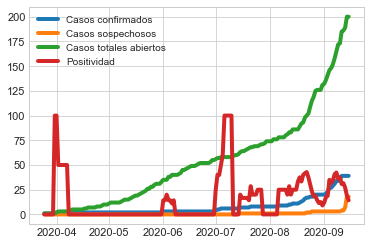

In [178]:
# graficar
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Confirmado'], label='Casos confirmados')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Sospechoso'], label='Casos sospechosos')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Total'], label='Casos totales abiertos')
plt.plot(tabla_casos_por_periodos.index, tabla_casos_por_periodos['Positividad'] * 100, label='Positividad')
plt.legend(loc='upper left')


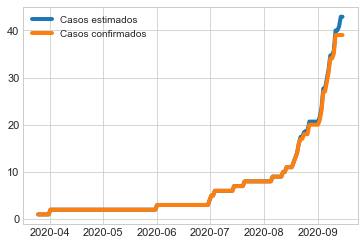

In [179]:
# estimar casos que serán confirmados eventualmente, según la positividad de los últimos días
tabla_casos_diarios['Estimado'] = tabla_casos_diarios['Confirmado'] + tabla_casos_diarios['Sospechoso'] * tabla_casos_diarios['Positividad']

# corregir datos del último día según hora de corte (17:45hs)
tabla_casos_diarios.loc[tabla_casos_diarios.index[-1], 'Estimado'] *= 24 / 17.75

# calcular acumulados de los casos estimados
tabla_casos_acumulados['Estimado'] = tabla_casos_diarios['Estimado'].cumsum()

# graficar
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Estimado'], label='Casos estimados')
plt.plot(tabla_casos_acumulados.index, tabla_casos_acumulados['Confirmado'], label='Casos confirmados')
plt.legend(loc='upper left')

In [180]:
# copiar tabla de datos y agregar columna con nombre 'fecha'
datos = tabla_casos_acumulados.copy()
datos['fecha'] = datos.index
datos = datos.reset_index(drop=True)


## Códigos del modelo

### Función para correr el modelo

In [181]:
def modelo_SEIR(tabla_datos, fila_inicio=0, fila_fin=-1):

    '''
    Modelo SEIR de paso diario

    Variables de entrada:
        tabla_datos: dataframe con (al menos) las siguientes columnas:
            R0: parámetro R0, un valor para cada fila/día
            Alpha: parámetro Alpha, un valor para cada fila/día
            Gamma: parámetro Gamma, un valor para cada fila/día
            Beta: parámetro Beta (se calcula a partir de R0 y Gamma)
            S: individuos susceptibles, valor para fila inicial
            E: individuos expuestos, valor para fila inicial
            I: individuos infectados, valor para fila inicial
            Ia: individuos infectados acumulados, valor para fila inicial
            R: individuos recuperados/removidos, valor para fila inicial
        fila_inicio: fila correspondiente al día 0 de la simulación (default comienza en fila 0)
        fila_fin: fila correspondiente al último día de la simulación (default hasta la última fila)
    
    Salida: mismo dataframe de entrada con los resultados de individuos S, E, I, R, Ia
    '''

    # hacer una copia de los datos (para no modificar la tabla de datos original)
    datos = tabla_datos.copy()

    # si no se ingresa valor de última fila, contar las filas
    if(fila_fin==-1): fila_fin = len(datos.index) - 1

    for d in range(fila_inicio, fila_fin):

        # leer valores dia actual
        S = datos.loc[d,'S']
        E = datos.loc[d,'E']
        I = datos.loc[d,'I']
        R = datos.loc[d,'R']
        T = S+I+R

        # leer parámetros día actual
        R0 = datos.loc[d,'R0']
        alpha = datos.loc[d,'Alpha']
        gamma = datos.loc[d,'Gamma']
        
        # calcular Beta a partir del R0 y escribirlo en la tabla
        beta = R0 * gamma
        datos.loc[d, 'Beta'] = beta
        
        # calcular valores día siguiente
        S1 = S - beta * S * I/T
        E1 = E + beta * S * I/T - alpha * E
        I1 = I + alpha * E + - gamma * I
        R1 = R + I * gamma
        Ia1 = I1 + R1

        # escribir datos día siguiente
        datos.loc[d+1,'S'] = S1
        datos.loc[d+1,'E'] = E1
        datos.loc[d+1,'I'] = I1
        datos.loc[d+1,'R'] = R1
        datos.loc[d+1,'Ia'] = Ia1

    # resultado
    return datos

### Función para ajustar el modelo

Función que ajusta los parámetros del modelo, minimizando la diferencia entre valores observados y simulados.

In [182]:
import random
from sklearn.metrics import mean_squared_error
from math import sqrt

def ajustar_modelo(modelo, datos, serie_estimados, serie_observados, inicio_ajuste=0, fin_ajuste=-1, variacion_aleatoria=0.05, maximo_iteraciones=1000, maximo_iteraciones_sin_cambios=150):

    '''
    Función para ajustar parámetros de modelos SEIR de paso diario
    Variables de entrada:
    modelo                          función del modelo a ejecutar
    datos                           tabla de datos con las variables de entrada del modelo
    serie_estimados                 nombre de la serie que contiene los datos estimados por el modelo 
    serie_observados                nombre de la serie que contiene los datos observados
    inicio_ajuste                   fila a partir de la cual se comparan observado y estimado (por defecto la primera fila)
    fin_ajuste                      fila a hasta la cual se comparan observado y estimado (por defecto la última fila)
    variacion_aleatoria             proporción en la que se varían los parámetros en cada iteración
    maximo_iteraciones              cantidad máxima de iteraciones
    maximo_iteraciones_sin_cambios  cantidad de iteraciones sin cambios para considerar ajustado el modelo
    '''

    # hacer una copia de los datos de entrada
    ajuste_preliminar = datos.copy()
    # contar la cantidad de datos observados disponibles
    cantidad_datos = ajuste_preliminar[serie_observados].count()
    ultima_fila = cantidad_datos - 1
    # chequear si se ingresó un valor para la última fila a considerar para el ajuste
    if(fin_ajuste==-1): fin_ajuste=ultima_fila
    # valor inicial rmse
    mejor_rmse = -1
    
    # iterar para mejorar el ajuste, hasta el valor máximo permitido
    for i in range(maximo_iteraciones):

        # correr el modelo para la tabla completa
        ajuste_preliminar = modelo(ajuste_preliminar, 0, ultima_fila)

        # calcular RMSE para el período de ajuste (desde inicio_ajuste hasta fin_ajuste)
        datos_estimados  = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_estimados]
        datos_observados = ajuste_preliminar.loc[inicio_ajuste:fin_ajuste, serie_observados]
        rmse = sqrt(mean_squared_error(datos_estimados, datos_observados))

        # verificar si el RMSE mejoró (o si es la primera iteración)
        if(rmse<mejor_rmse or i==0): # and minima_diferencia>=0):
            mejor_rmse = rmse
            mejor_ajuste = ajuste_preliminar.copy()
            iteraciones_sin_cambios = 0

        # si no, volver al mejor ajuste anterior
        else:
            ajuste_preliminar = mejor_ajuste.copy()
            iteraciones_sin_cambios = iteraciones_sin_cambios + 1

        # aleatorizar los parámetros para una nueva iteración
        aleatorizar_parametros(ajuste_preliminar, variacion_aleatoria)

        # mostrar progreso
        if(i % 100)==0:
            print(".", end=" ")

        # si ya hubo muchas iteraciones sin que haya cambios, terminar el ajuste
        if(iteraciones_sin_cambios > maximo_iteraciones_sin_cambios): break

    # devolver como resultado el mejor mejor_ajuste obtenido
    return mejor_ajuste


def aleatorizar_parametros(datos, variacion_aleatoria):

    # leer los valores actuales de los parámetros
    R0  = datos.loc[0,'R0']
    S   = datos.loc[0,'S']
    E   = datos.loc[0,'E']
    I   = datos.loc[0,'I']
    Ia  = datos.loc[0,'Ia']
    R   = datos.loc[0,'R']
    T   = S + E + I + R
    
    # aleatorizar el parámetro R0
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R0  = R0  * multiplicador

    # aleatorizar los valores de E e I
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    E  = E  * multiplicador
    I  = I  * multiplicador

    # aleatorizar el valor de R
    multiplicador = random.uniform(1-variacion_aleatoria, 1+variacion_aleatoria)
    R = R * multiplicador
    
    # recalcular el resto de las variables iniciales
    Ia = R + I
    S = T - E - I - R

    # actualizar los valores en la planilla de datos
    datos['R0']        = R0
    datos.loc[0, 'S']  = S
    datos.loc[0, 'E']  = E
    datos.loc[0, 'I']  = I
    datos.loc[0, 'Ia'] = Ia
    datos.loc[0, 'R']  = R

## Ajuste de parámetros

### Ajuste para el primer período

In [183]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_1 + 1
datos_ajuste = datos.tail(filas).reset_index(drop=True)

# agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
## valores de R0 y Beta a partir de los resultados del ajuste con nexo/sin nexo
datos_ajuste['R0']    = R0
datos_ajuste['Alpha'] = alpha
datos_ajuste['Beta']  = beta
datos_ajuste['Gamma'] = gamma

datos_ajuste['R0']    = 1.5829804653499224  # valor ajuste publicado

# estimar valores iniciales de casos expuestos y activos
casos_primera_semana = datos_ajuste.loc[7, columna_datos] - datos_ajuste.loc[0, columna_datos]
I = casos_primera_semana
E = I * gamma / alpha

# tomar valores iniciales de casos acumulados
Ia  = datos_ajuste.loc[0, columna_datos]
R = Ia - I
S = T - E - I - R

# agregar columnas para los compartimientos del modelo y los valores iniciales en la primera fila
datos_ajuste.loc[0, 'S']     = S
datos_ajuste.loc[0, 'E']     = E
datos_ajuste.loc[0, 'I']     = I
datos_ajuste.loc[0, 'Ia']    = Ia
datos_ajuste.loc[0, 'R']     = R

# correr la función de ajuste de parámetros
resultado_ajuste_1 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_1.loc[0,'R0'])

........R0 ajustado: 1.4689689587313521


### Ajuste para el segundo período

In [184]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_2 + 1
datos_ajuste = resultado_ajuste_1.tail(filas).reset_index(drop=True)

datos_ajuste['R0']    = 1.5839019295856263  # valor ajuste publicado


# correr la función de ajuste de parámetros
resultado_ajuste_2 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_2.loc[0,'R0'])

..........R0 ajustado: 1.2079059425695122


### Ajuste para el tercer período

In [185]:
# recortar la tabla de datos y dejar sólo las filas que se van a usar para el ajuste
filas = duracion_lag + duracion_ajuste_3 + 1
datos_ajuste = resultado_ajuste_2.tail(filas).reset_index(drop=True)

datos_ajuste['R0']    = 1.703779471291687  # valor ajuste publicado


# correr la función de ajuste de parámetros
resultado_ajuste_3 = ajustar_modelo(modelo_SEIR, datos_ajuste, 'Ia', columna_datos, duracion_lag, variacion_aleatoria=0.05)

# mostrar R0 ajustado
print('R0 ajustado:',resultado_ajuste_3.loc[0,'R0'])

......R0 ajustado: 0.9317628527585904


### Resultado

Graficar el resultado de los 3 ajustes en comparación con los datos observados

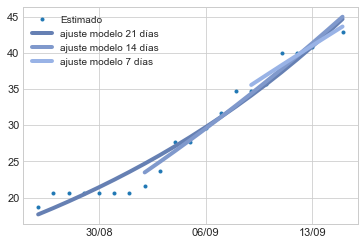

In [186]:
# casos observados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1[columna_datos].tail(duracion_ajuste_1), 
    '.', 
    label=columna_datos)

# casos estimados
plt.plot(
    resultado_ajuste_1['fecha'].tail(duracion_ajuste_1),
    resultado_ajuste_1['Ia'].tail(duracion_ajuste_1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_ajuste_2['fecha'].tail(duracion_ajuste_2),
    resultado_ajuste_2['Ia'].tail(duracion_ajuste_2), 
    '-', 
    color=[0.5,0.6,0.8],
    label='ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_ajuste_3['fecha'].tail(duracion_ajuste_3),
    resultado_ajuste_3['Ia'].tail(duracion_ajuste_3), 
    '-', 
    color=[0.6,0.7,0.9],
    label='ajuste modelo '+str(duracion_ajuste_3)+' días')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))

## Proyecciones

### Proyección simple

In [187]:
# copiar columnas de datos de la tabla de resultados del ajuste
datos_simulacion_1 = resultado_ajuste_1.tail(duracion_ajuste_1).reset_index(drop=True)
datos_simulacion_2 = resultado_ajuste_2.tail(duracion_ajuste_2).reset_index(drop=True)
datos_simulacion_3 = resultado_ajuste_3.tail(duracion_ajuste_3).reset_index(drop=True)

# función para agregar filas con los días subsiguientes para la proyección del modelo
def armar_tabla_proyeccion(datos_simulacion, duracion_proyeccion):

    for i in range(duracion_proyeccion):
        ultima_fila = datos_simulacion.index.max()
        ultima_fecha = datos_simulacion.loc[ultima_fila, 'fecha']
        datos_simulacion.loc[ultima_fila + 1, 'fecha'] = ultima_fecha + pd.Timedelta(days=1)

    # agregar columnas para los parámetros del modelo, e incluir los valores iniciales en todas las filas
    datos_simulacion['R0']    = datos_simulacion.loc[0, 'R0']
    datos_simulacion['Alpha'] = datos_simulacion.loc[0, 'Alpha']
    datos_simulacion['Beta']  = datos_simulacion.loc[0, 'Beta']
    datos_simulacion['Gamma'] = datos_simulacion.loc[0, 'Gamma']

# llamar a la función para los 3 períodos
armar_tabla_proyeccion(datos_simulacion_1, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_2, duracion_proyeccion)
armar_tabla_proyeccion(datos_simulacion_3, duracion_proyeccion)

# correr las 3 simulaciones
resultado_simulacion_1 = modelo_SEIR(datos_simulacion_1)
resultado_simulacion_2 = modelo_SEIR(datos_simulacion_2)
resultado_simulacion_3 = modelo_SEIR(datos_simulacion_3)


### Resultado

(737663.0, 737699.0)

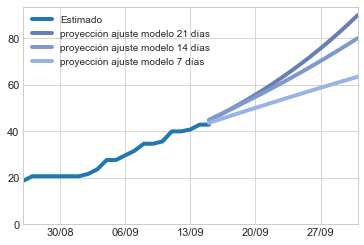

In [188]:
# casos observados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1[columna_datos], 
    '-', 
    label=columna_datos)

# casos estimados
plt.plot(
    resultado_simulacion_1['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_1['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.4,0.5,0.7],
    label='proyección ajuste modelo '+str(duracion_ajuste_1)+' días')
plt.plot(
    resultado_simulacion_2['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_2['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.5,0.6,0.8],
    label='proyección ajuste modelo '+str(duracion_ajuste_2)+' días')
plt.plot(
    resultado_simulacion_3['fecha'].tail(duracion_proyeccion + 1),
    resultado_simulacion_3['Ia'].tail(duracion_proyeccion + 1), 
    '-', 
    color=[0.6,0.7,0.9],
    label='proyección ajuste modelo '+str(duracion_ajuste_3)+' días')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

## Intervalo de variación

### Identificar ajuste máximo y mínimo

In [189]:
# ver los valores de casos estimados finales en cada simulación
ultima_fila = len(resultado_simulacion_1.index) -1
valor_final_simulacion_1 = resultado_simulacion_1.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_2.index) -1
valor_final_simulacion_2 = resultado_simulacion_2.loc[ultima_fila,'Ia']
ultima_fila = len(resultado_simulacion_3.index) -1
valor_final_simulacion_3 = resultado_simulacion_3.loc[ultima_fila,'Ia']

# calcular máximo y mínimo
maximo = max([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])
minimo = min([valor_final_simulacion_1, valor_final_simulacion_2, valor_final_simulacion_3])

# identificar cuál simulación es la que da el valor máximo
if valor_final_simulacion_1 == maximo: maximo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == maximo: maximo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == maximo: maximo_proyeccion = resultado_simulacion_3.copy()

# identificar cuál simulación es la que da el valor mínimo
if valor_final_simulacion_1 == minimo: minimo_proyeccion = resultado_simulacion_1.copy()
if valor_final_simulacion_2 == minimo: minimo_proyeccion = resultado_simulacion_2.copy()
if valor_final_simulacion_3 == minimo: minimo_proyeccion = resultado_simulacion_3.copy()

# recortar las tablas para que tengan la misma duración, y que inicien donde terminan los datos observados
maximo_proyeccion = maximo_proyeccion.tail(duracion_proyeccion + 3).reset_index(drop=True)
minimo_proyeccion = minimo_proyeccion.tail(duracion_proyeccion + 3).reset_index(drop=True)


(737663.0, 737699.0)

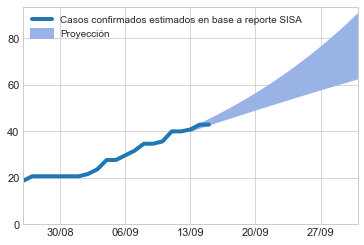

In [190]:
# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['Estimado'], 
    '-', 
    label='Casos confirmados estimados en base a reporte SISA')

# casos estimados
plt.fill_between(
    maximo_proyeccion['fecha'],
    minimo_proyeccion['Ia'], 
    maximo_proyeccion['Ia'], 
    color=[0.6,0.7,0.9],
    lw=4,
    label='Proyección')

# ubicación leyeda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])

Aumentar el R0 para el valor máximo y disminuirlo para el valor mínimo, un % diario.

In [191]:
filas = len(maximo_proyeccion.index)
variacion_diaria = 0.012

R0 = maximo_proyeccion.loc[0,'R0']
maximo_proyeccion_aumento_R0          = maximo_proyeccion.copy()
maximo_proyeccion_aumento_R0['R0']    = ( 1 + pd.Series(range(filas)) * variacion_diaria ) * R0
maximo_proyeccion_aumento_R0          = modelo_SEIR(maximo_proyeccion_aumento_R0)

R0 = minimo_proyeccion.loc[0,'R0']
minimo_proyeccion_disminucion_R0          = minimo_proyeccion.copy()
minimo_proyeccion_disminucion_R0['R0']    = ( 1 - pd.Series(range(filas)) * variacion_diaria ) * R0
minimo_proyeccion_disminucion_R0          = modelo_SEIR(minimo_proyeccion_disminucion_R0)


Text(0.5, 0, 'Fecha de apertura del caso en SISA')

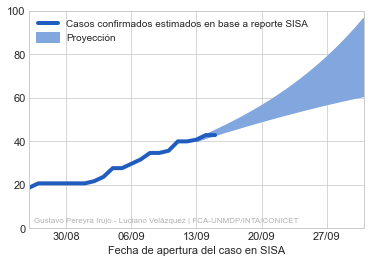

In [192]:
# casos estimados variando R0
plt.fill_between(
    maximo_proyeccion['fecha'],
    minimo_proyeccion_disminucion_R0['Ia'], 
    maximo_proyeccion_aumento_R0['Ia'], 
    color=[0.51,0.65,0.87],
    lw=4,
    label='Proyección')


# casos confirmados
plt.plot(
    resultado_simulacion_1['fecha'],
    resultado_simulacion_1['Estimado'], 
    '-', 
    color=[0.13,0.36,0.75],
    label='Casos confirmados estimados en base a reporte SISA')
    
# ubicación leyenda
plt.legend(loc='upper left')
# formato de fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
# escala semanal
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(6))
# escala ejes x e y
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left =resultado_simulacion_1['fecha'].iloc[ 0])
plt.gca().set_xlim(right=resultado_simulacion_1['fecha'].iloc[-1])
# leyenda eje x
plt.title('Gustavo Pereyra Irujo - Luciano Velázquez | FCA-UNMDP/INTA/CONICET', fontsize=8, horizontalalignment='left', x=0.015, y=0.0, color=[0.7,0.7,0.7])

plt.xlabel('Fecha de apertura del caso en SISA', fontsize=11)